In [38]:
import os
import sys
import json
import math

import ROOT

from DevTools.Plotter.style import getStyle
import DevTools.Plotter.CMS_lumi as CMS_lumi
import DevTools.Plotter.tdrstyle as tdrstyle

ROOT.gROOT.SetBatch(ROOT.kTRUE)
ROOT.gROOT.ProcessLine("gErrorIgnoreLevel = 1001;")
tdrstyle.setTDRStyle()
ROOT.gStyle.SetPalette(1)

cmssw_base = os.environ['CMSSW_BASE']

import rootnotes
import rootprint
canvas = rootnotes.default_canvas()

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: icanvas


In [2]:
def setStyle(pad,position=11,preliminary=True):
    period_int = 4
    CMS_lumi.wrtieExtraText = preliminary
    CMS_lumi.extraText = "Preliminary"
    CMS_lumi.lumi_13TeV = "%0.1f fb^{-1}" % (float(2318)/1000.)
    CMS_lumi.CMS_lumi(pad,period_int,position)


In [135]:
#%%rootprint

hppFile = '{0}/src/flat/Hpp4l/HPlusPlusHMinusMinusHTo4L_M-500_13TeV-pythia8.root'.format(cmssw_base)
zzFile = '{0}/src/flat/Hpp4l/ZZTo4L_13TeV_powheg_pythia8.root'.format(cmssw_base)
histName = 'default/hppMass'
hpptfile = ROOT.TFile.Open(hppFile,'READ')
zztfile = ROOT.TFile.Open(zzFile,'READ')
hppHist = hpptfile.Get(histName).Rebin(10)
zzHist = zztfile.Get(histName).Rebin(10)

stack = ROOT.THStack('stack','stack')
stack.Add(zzHist)
stack.Add(hppHist)

hist = stack.GetStack().Last()

hist.GetXaxis().SetTitle('m_{l^{+}l^{+}} (GeV)')
hist.GetYaxis().SetTitle('Events/10.0 GeV')

w = ROOT.RooWorkspace()
w.factory('Exponential::bg(x[100,1200],decay[-10.,0])')
w.factory('RooVoigtian::sig(x,mean[480,520],width[0,50],sigma[0,1])')
#w.factory('RooCBShape::sig(x,mean[480,520],sigma[0,25],a[0,100],n[0,100])')
w.factory('SUM::model(bgscale[0,100]*bg,sigscale[0,100]*sig)')


x = w.var('x')
model = w.pdf('model')

frame = x.frame()

datahist = ROOT.RooDataHist('d','d',ROOT.RooArgList(x),hist)
datahist.plotOn(frame)

model.fitTo(datahist,ROOT.RooFit.Save())
model.plotOn(frame)
model.plotOn(frame,ROOT.RooFit.Components('bg'),ROOT.RooFit.LineColor(ROOT.kGreen))
model.plotOn(frame,ROOT.RooFit.Components('sig'),ROOT.RooFit.LineColor(ROOT.kRed))


#frame.Draw()

hist.SetMarkerStyle(20)
hist.SetMarkerSize(1)
hist.Draw("e0")
fit = frame.getObject(1)
bgplot = frame.getObject(2)
sigplot = frame.getObject(3)

bgplot.Draw("same")
sigplot.Draw("same")
fit.Draw("same")

setStyle(canvas)



[#1] INFO:DataHandling -- RooDataHist::adjustBinning(d): fit range of variable x expanded to nearest bin boundaries: [100,1200] --> [100,1200]
[#1] INFO:InputArguments -- RooAbsData::plotOn(d) INFO: dataset has non-integer weights, auto-selecting SumW2 errors instead of Poisson errors
[#0] WARNING:InputArguments -- RooAbsPdf::fitTo(model) WARNING: a likelihood fit is request of what appears to be weighted data. 
       While the estimated values of the parameters will always be calculated taking the weights into account, 
       there are multiple ways to estimate the errors on these parameter values. You are advised to make an 
       explicit choice on the error calculation: 
           - Either provide SumW2Error(kTRUE), to calculate a sum-of-weights corrected HESSE error matrix 
             (error will be proportional to the number of events)
           - Or provide SumW2Error(kFALSE), to return errors from original HESSE error matrix
             (which will be proportional to th

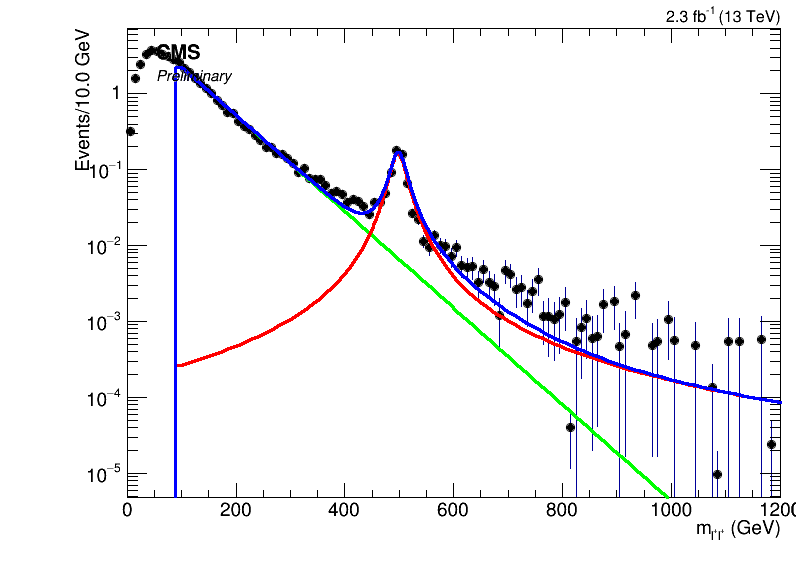

In [136]:
#print 'decay', w.var('decay').getVal()
#print 'mean', w.var('mean').getVal()
#print 'sigma', w.var('sigma').getVal()
#print 'width', w.var('width').getVal()
#print 'sigscale', w.var('sigscale').getVal()
#print 'bgscale', w.var('bgscale').getVal()
canvas.SetLogy(1)
canvas

In [4]:
# load fiducial
masses = [200,300,400,500,600,700,800,900,1000]
genChannels = []
higgsChannels = ['ee','em','et','mm','mt','tt']
for hpp in higgsChannels:
    for hmm in higgsChannels:
        genChannels += [hpp+hmm]

fiducials = {}
decays = {}
for chan in genChannels:
    fiducials[chan] = []
    decays[chan] = []

for mass in masses:
    genfile = '{0}/src/jsons/Hpp4l/genCounts.{1}.json'.format(cmssw_base, mass)
    recofile = '{0}/src/jsons/Hpp4l/recoCounts.{1}.json'.format(cmssw_base, mass)
    with open(genfile) as f:
        gen = json.load(f)
    with open(recofile) as f:
        reco = json.load(f)
    for chan in genChannels:
        fiducials[chan] += [gen['fiducial'][chan]]
        decays[chan] += [gen['decay'][chan]]


TROOT::Append:0: RuntimeWarning: Replacing existing TH1: ah (Potential memory leak).


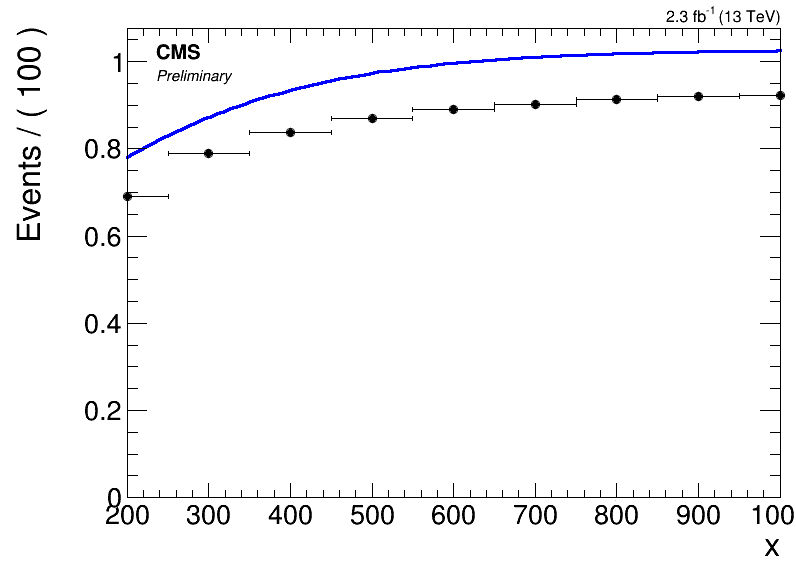

In [81]:
acceptance = ROOT.TGraph(len(masses))
acceptHist = ROOT.TH1F('ah','ah',9,150,1050)
for i in range(len(masses)):
    num = sum([fiducials[chan][i] for chan in genChannels if 't' not in chan])
    denom = sum([decays[chan][i] for chan in genChannels if 't' not in chan])
    eff = float(num)/denom if denom else 0.
    err = eff * (float(num)/num**2+float(denom)/denom**2)**0.5
    acceptance.SetPoint(i,masses[i],eff)
    acceptHist.SetBinContent(i+1,eff)
    acceptHist.SetBinError(i+1,err)
    


x = ROOT.RooRealVar('x','x',200,1000)
frame = x.frame()
a = ROOT.RooRealVar('a','a',0.7,0.9)
b = ROOT.RooRealVar('b','b',0,100)
c = ROOT.RooRealVar('c','c',0,500)
effFunc = ROOT.RooFormulaVar('effFunc','a/(1+exp(-(x-b)/c))',ROOT.RooArgList(a,b,c,x))
cut = ROOT.RooCategory('cut','cutr')
cut.defineType('accept',1)
cut.defineType('reject',0)
effPdf = ROOT.RooEfficiency('effPdf','effPdf',effFunc,cut,'accept')
datahist = ROOT.RooDataHist('d','d',ROOT.RooArgList(x),acceptHist)
effPdf.fitTo(datahist,ROOT.RooFit.Save())
datahist.plotOn(frame)
effPdf.plotOn(frame)

frame.Draw()

#acceptHist.Draw('p')
#acceptance.Draw("p")
#acceptance.GetXaxis().SetTitle('m_{#Phi^{#pm#pm}} (GeV)')
#acceptance.GetYaxis().SetTitle('Acceptance')
#fit = frame.getObject(1)
#fit.Draw('same')

setStyle(canvas)

canvas

In [78]:
print a.getVal()
print b.getVal()
print c.getVal()

0.75205744614
0.272956473975
1205.05400677
